In [ ]:
import src.db.dataService as db
import src.db.preprocess as preprocess
import pandas as pd

from get_location_features import get_location_features_by_squares, get_location_features_by_radius, get_elevation_data

connection = db.create_connection()
sensors_data = pd.read_csv(
    "data/air-quality-data-from-extensive-network-of-sensors/sensor_locations.csv").set_index(
    'id')
features_by_squares = [
    ('grid250_dochod', 'dochod_bud_pra'),
    ('grid250_demo_ext', 'populacja_razem'),
    ('grid250_demo_ext', 'budynki_all'),
    ('grid250_demo_ext', 'budynki_mieszkalne'),
]
squares = [9, 16, 25]

features_by_radius = {
    'Przystanek autobusowy': [1000, 2000],
    'Oddział Banku': [1000, 2000],
    'Przystanek tramwajowy': [1000, 2000],
    'Hipermarket': [1000, 2000],
    'Stacja Paliw': [1000, 3000]
}

In [2]:
sensors_data = get_location_features_by_squares(sensors_data, connection, features_by_squares, squares)
sensors_data = get_location_features_by_radius(sensors_data, connection, features_by_radius)
sensors_data = get_elevation_data(sensors_data)

In [33]:

print(sensors_data.head())

      latitude  longitude  dochod_bud_pra_9  dochod_bud_pra_16  \
id                                                               
3    50.057748  19.961375             47264              78228   
140  50.057747  19.961374             47264              78228   
142  50.084816  19.878066             47303              74255   
147  50.048924  19.962262             41575              77522   
169  50.048699  20.101569             23303              40365   

     dochod_bud_pra_25  populacja_razem_9  populacja_razem_16  \
id                                                              
3               113184               3743                6098   
140             113184               3743                6098   
142             121276               1303                1959   
147             116384                991                2965   
169              40365                 26                  59   

     populacja_razem_25  budynki_all_9  budynki_all_16    ...      \
id          

In [56]:
def get_target_variables():
    december_df = pd.read_csv("data/air-quality-data-from-extensive-network-of-sensors/december-2017.csv")
    ms = december_df.mean()
    means = pd.DataFrame({ms.index[i*6].split('_')[0]: list(ms[i*6:i*6+6]) for i in range(int(ms.shape[0]/6))}).T
    means.columns = ['temperature', 'humidity', 'pressure', 'pm1', 'pm10', 'pm25']
    means.index = means.index.astype('int64')
    return means[['pm1', 'pm10', 'pm25']]

In [57]:
y = get_target_variables()
y.head()

,pm1,pm10,pm25
140,36.632582,39.072790,67.102253
142,NaN,NaN,NaN
147,NaN,NaN,NaN
169,24.949239,25.332487,40.593909
170,31.023173,34.793226,53.909091


In [62]:
data = pd.concat([y, sensors_data], axis=1, join='inner')
data = data.dropna()

In [64]:
data.shape

(47, 28)

In [67]:
data.to_csv('./processed_data.csv')

In [11]:
import pandas as pd
data = pd.read_csv('./processed_data.csv', index_col=0)

In [29]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

discrete = ['Przystanek autobusowy_1000', 'Przystanek autobusowy_2000',
       'Oddział Banku_1000', 'Oddział Banku_2000',
       'Przystanek tramwajowy_1000', 'Przystanek tramwajowy_2000',
       'Hipermarket_1000', 'Hipermarket_2000', 'Stacja Paliw_1000',
       'Stacja Paliw_3000']
continuous = ['pm1', 'pm10', 'pm25', 'dochod_bud_pra_9',
       'dochod_bud_pra_16', 'dochod_bud_pra_25', 'populacja_razem_9',
       'populacja_razem_16', 'populacja_razem_25', 'budynki_all_9',
       'budynki_all_16', 'budynki_all_25', 'budynki_mieszkalne_9',
       'budynki_mieszkalne_16', 'budynki_mieszkalne_25', 'elevation']



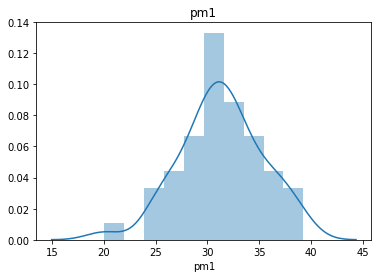

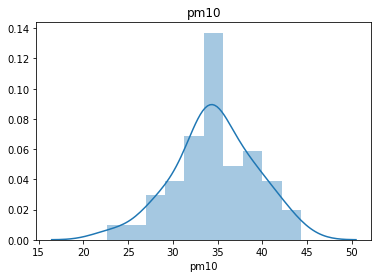

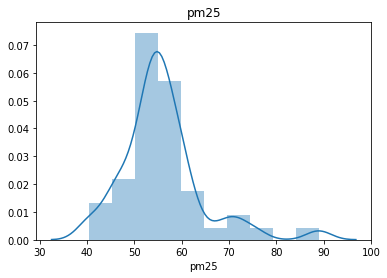

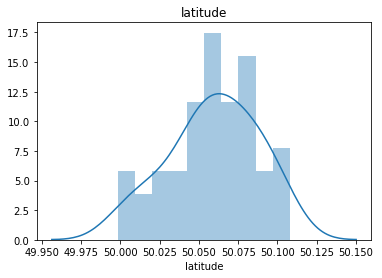

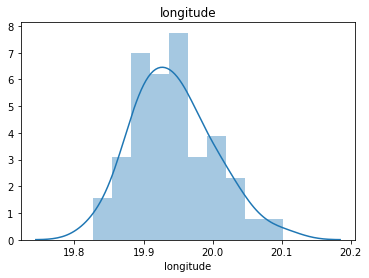

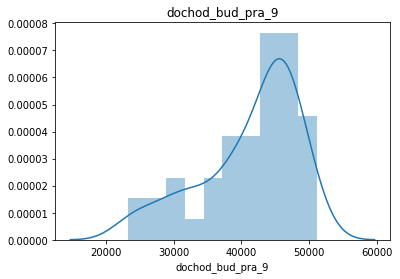

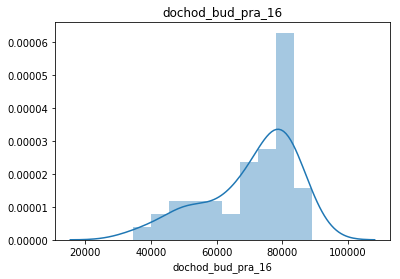

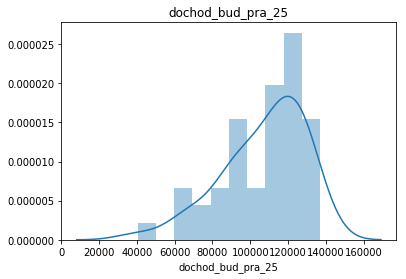

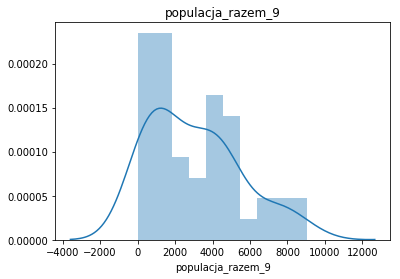

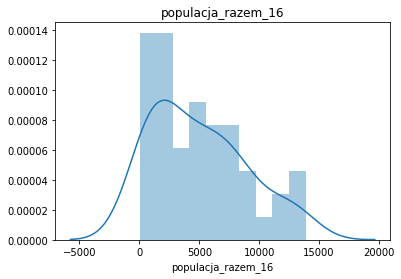

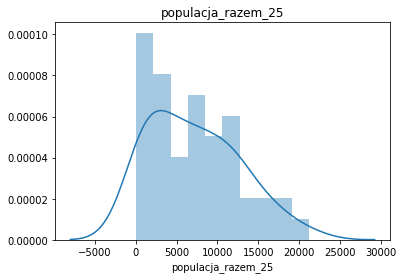

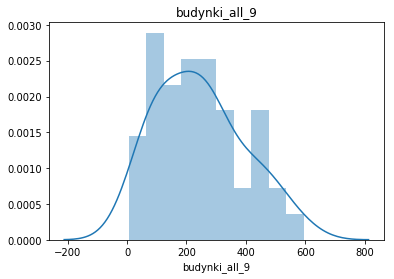

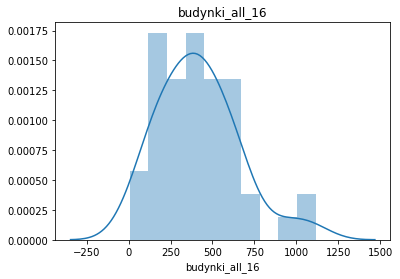

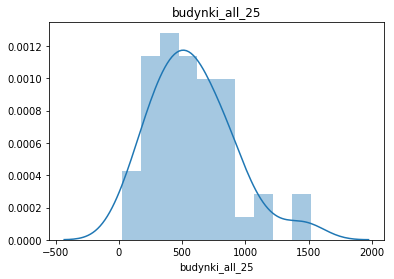

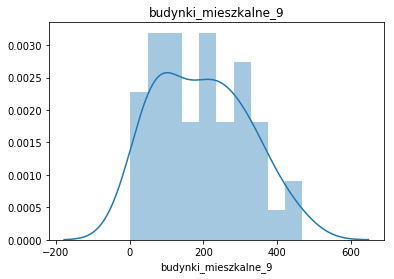

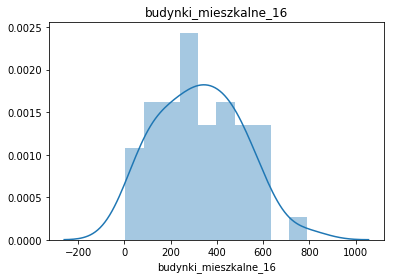

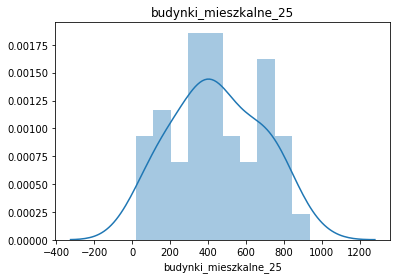

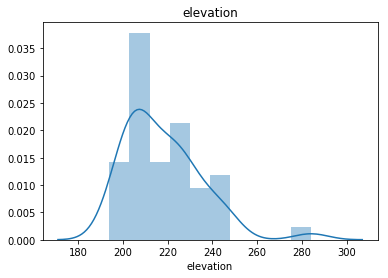

In [21]:
for attr in continuous:
    sns.distplot(data[attr], bins=10).set_title(attr)
    plt.figure()

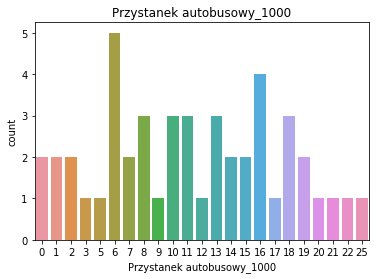

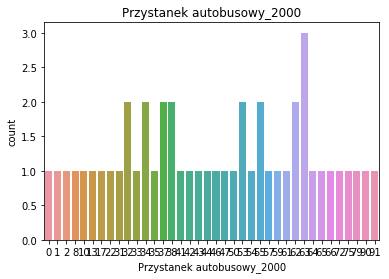

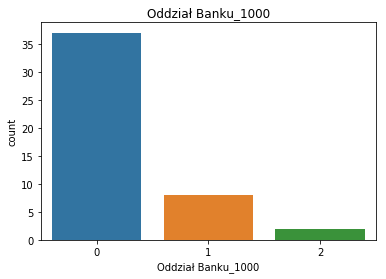

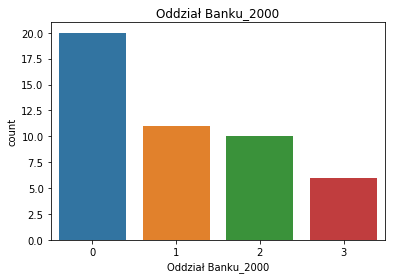

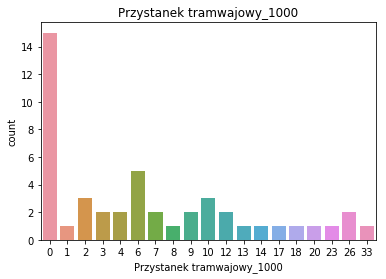

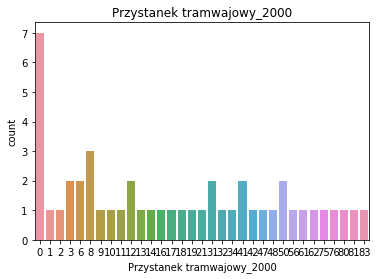

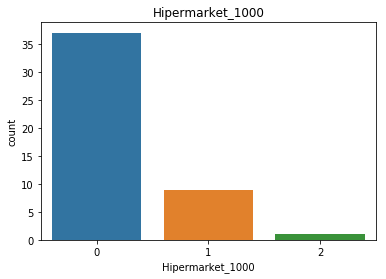

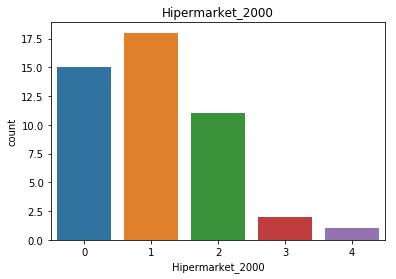

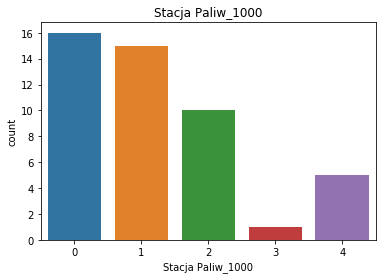

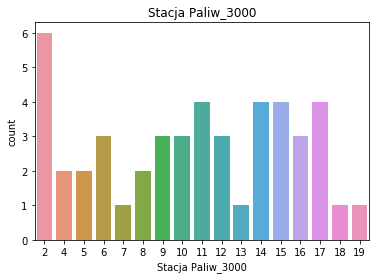

In [23]:
for attr in discrete:
    sns.countplot(data[attr]).set_title(attr)
    plt.figure()

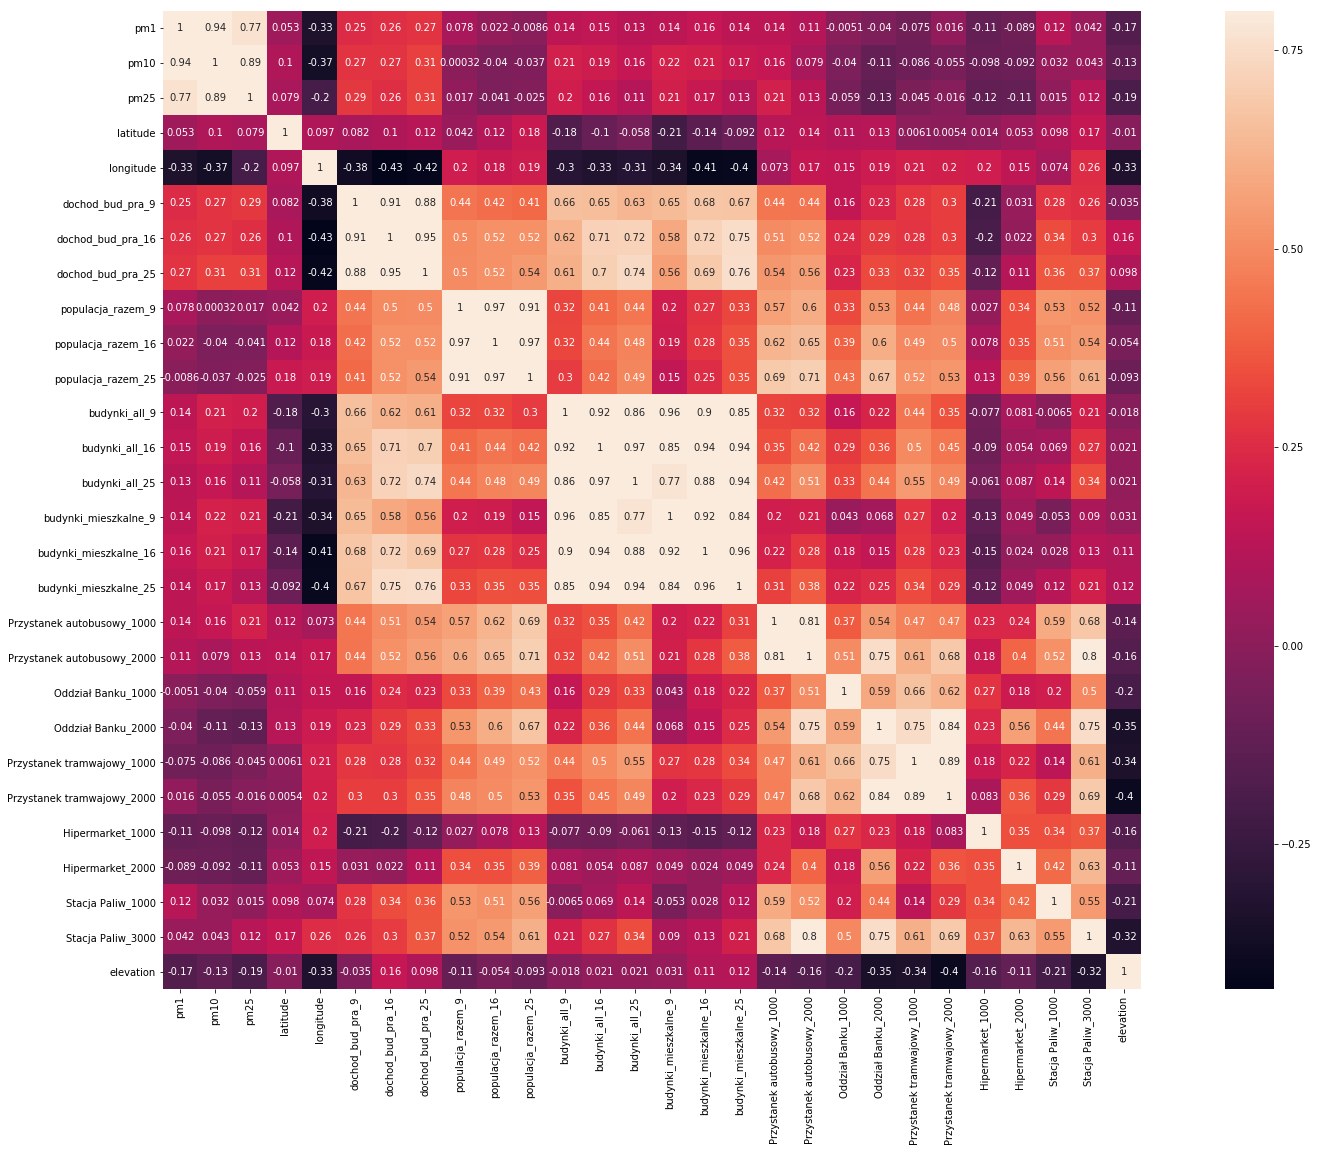

In [32]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(30, 18))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

In [39]:
data['budynki_niemieszkalne_9'] = data['budynki_all_9'] - data['budynki_mieszkalne_9']
data['populacja_na_budynek_9'] = data['populacja_razem_9'] - data['budynki_mieszkalne_9']
data['budynki_niemieszkalne_na_populacje_9'] = data['budynki_niemieszkalne_9'] / (data['populacja_razem_9'] + 1)

In [41]:
y = data['pm25']
X = data.drop(['pm25', 'pm10', 'pm1', 'longitude', 'latitude'], axis=1)

In [47]:
from xgboost import XGBRegressor

regressor = XGBRegressor()


In [49]:
regressor.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [51]:
import pickle
with open('./saved_model', 'wb') as f:
    pickle.dump(regressor, f)


In [63]:

grid = pd.read_csv('./grid_locations.csv', index_col=0, header=None)
grid.columns = ['longitude', 'latitude']

In [66]:
import src.db.dataService as db
import src.db.preprocess as preprocess
connection = db.create_connection()
from get_location_features import get_all_features

grid_processed = get_all_features(grid, connection)
print(grid.head())

   longitude  latitude  dochod_bud_pra_9  dochod_bud_pra_16  \
0                                                             
0  19.826993  49.99848             19917              29131   
1  19.854451  49.99848             14609              29246   
2  19.881908  49.99848             14398              34799   
3  19.909366  49.99848             45613              76401   
4  19.936823  49.99848             42329              74248   

   dochod_bud_pra_25  populacja_razem_9  populacja_razem_16  \
0                                                             
0              46965                 93                 147   
1              52527                159                 245   
2              49735                 23                  44   
3             109682               1395                2573   
4             107282                904                1145   

   populacja_razem_25  budynki_all_9  budynki_all_16    ...      \
0                                                

In [68]:
grid_processed.to_csv("./data/grid_processed.csv")

In [69]:
grid_processed['budynki_niemieszkalne_9'] = grid_processed['budynki_all_9'] - grid_processed['budynki_mieszkalne_9']
grid_processed['populacja_na_budynek_9'] = grid_processed['populacja_razem_9'] - grid_processed['budynki_mieszkalne_9']
grid_processed['budynki_niemieszkalne_na_populacje_9'] = grid_processed['budynki_niemieszkalne_9'] / (grid_processed['populacja_razem_9'] + 1)
X_grid = grid_processed.drop(['longitude', 'latitude'], axis=1)

In [72]:
grid_out = regressor.predict(X_grid)

In [73]:
grid_out

array([39.303783, 40.95151 , 40.989895, 56.547695, 61.97535 , 54.149376,
       57.524475, 48.92349 , 56.253975, 61.511   , 48.41681 , 41.12218 ,
       47.486996, 49.450726, 55.877613, 51.290813, 50.716152, 58.213604,
       56.0052  , 53.822834, 52.810246, 41.12218 , 51.504974, 56.889862,
       57.867577, 51.00029 , 54.05309 , 53.743923, 56.78727 , 42.012455,
       41.720165, 56.37593 , 38.71964 , 51.500202, 57.534863, 53.893414,
       44.202534, 52.35819 , 52.72128 , 42.012455, 57.937084, 41.28766 ,
       41.720165, 54.67668 , 57.576687, 58.02673 , 64.97492 , 54.606102,
       59.431   , 53.04538 , 47.75685 , 38.610477, 40.641186, 61.61772 ,
       53.304695, 58.04521 , 42.262558, 53.006084, 58.88524 , 41.941998,
       47.080086, 52.470303, 69.085846, 59.70921 , 54.082455, 55.53463 ,
       54.84028 , 50.575016, 56.679886, 54.52494 , 51.169624, 48.96138 ,
       57.74631 , 56.90717 , 56.922726, 55.827747, 51.140594, 52.01737 ,
       51.473244, 40.837826, 40.603718, 50.43792 , 

In [75]:
grid_with_predictions = grid[['longitude', 'latitude']]
grid_with_predictions['pm25'] = grid_out

/home/johnny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
grid_with_predictions

,longitude,latitude,pm25
0,,,
0,19.826993,49.998480,39.303783
1,19.854451,49.998480,40.951511
2,19.881908,49.998480,40.989895
3,19.909366,49.998480,56.547695
4,19.936823,49.998480,61.975349
5,19.964281,49.998480,54.149376
6,19.991739,49.998480,57.524475
7,20.019196,49.998480,48.923489
8,20.046654,49.998480,56.253975


In [77]:
grid_with_predictions.to_csv('out.csv')